## Adding Memory in Agentic Graph
### Creating the agent workflow

In [13]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

import os
from dotenv import load_dotenv
load_dotenv()

# loading the llm
api_key = os.getenv("GROQ_API")
llm = ChatGroq(model = "llama3-70b-8192", api_key = api_key)

# Loading the tavily tool
from langchain_tavily import TavilySearch
tavily_api_key = os.getenv("TAVILY_API")

tool = TavilySearch(max_results = 2)

In [14]:
#Defining custom function
def multipy(a:int,b:int)->int: # the doc string is very important
    """Multiply a and b # example of document string

    Args:
        a (int) : first int
        b (int) : second int

    Returns:
        int: output int
    """
    return(a*b)

#Creating the tools list 
tools = [tool,multipy]

#binding llm with tools
llm_with_tools = llm.bind_tools(tools)

# Initializing  State
class State(TypedDict): #TypedDict makes sure that the return type of this class is a dictionary
    messages:Annotated[list, add_messages]

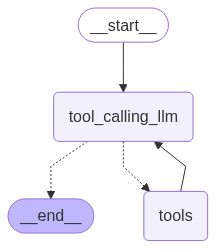

In [32]:
# Implementing ReAct Agent Architecture

# Creating StateGraph and the Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# defining the tool calling llm Node function
def tool_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

# Building the graph
graph_builder = StateGraph(State)

#Adding nodes
graph_builder.add_node("tool_calling_llm",tool_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Adding edges
graph_builder.add_edge(START,"tool_calling_llm" )
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message result from assistant is a tool call --> tools_condition routes to tools
    #If the latest message result from assistant is not a tool call --> tools_condition routes to END
    tools_condition)
graph_builder.add_edge("tools","tool_calling_llm")
# graph_builder.add_edge("tools",END)

#compilng the graph
graph_react = graph_builder.compile()
graph_react

# visualise the graph this way as well
from IPython.display import Image, display

try:
    display(Image(graph_react.get_graph().draw_mermaid_png()))

except Exception :
    pass

In [20]:
print('\noutput_1')
response_1 = graph_react.invoke({"messages":"Hello, My name is Shaun"})
for m in response_1["messages"]:
    m.pretty_print()

print('\noutput_2')
response_1 = graph_react.invoke({"messages":"What is my name"})
for m in response_1["messages"]:
    m.pretty_print()


output_1
================================ Human Message =================================

Hello, My name is Shaun
================================== Ai Message ==================================

Nice to meet you, Shaun! Is there something I can help you with or would you like to chat about something in particular?

output_2
================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have access to personal information about you. I'm here to help answer your questions and provide information on a wide range of topics. If you'd like to chat or ask a question, I'm happy to help!


### Adding Memory to the agentic graph

In [33]:
# Adding memory in the graph
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# we need to add this checkpoint while compiling
graph_react = graph_builder.compile(checkpointer = memory)

config = {"configurable":{"thread_id":"1"}} #thread id should be unique("1"). This will create an unique thread id

response_2 = graph_react.invoke({"messages":"Hi my name is Shaun"}, config=config)
response_2

{'messages': [HumanMessage(content='Hi my name is Shaun', additional_kwargs={}, response_metadata={}, id='b4f4be0a-3dbf-4481-adf6-e11da0014333'),
  AIMessage(content="Nice to meet you, Shaun! How's it going?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 2267, 'total_tokens': 2280, 'completion_time': 0.132281821, 'prompt_time': 0.088126292, 'queue_time': 0.23181289100000002, 'total_time': 0.220408113}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--8faf626d-ef53-4bb7-898d-19a73014c3ac-0', usage_metadata={'input_tokens': 2267, 'output_tokens': 13, 'total_tokens': 2280})]}

In [36]:
# response_2["messages"][-1]
response_3 = graph_react.invoke({"messages":"Hi what is my name"}, config=config)
# response_3

print(response_3["messages"][-1].content)

Your name is Shaun!


# Streaming

In [44]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

def superbot(state:State): #Adding a simple node
    return{"messages":[llm.invoke(state["messages"])]}

# creating the graph structure
graph = StateGraph(State)

#adding node
graph.add_node("superbot", superbot)

#adding edges
graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

#compiling the graph
graph = graph.compile(checkpointer=memory)
graph

#creating a thread
config = {"configurable": {"thread_id":"1"}}

#invoking the graph
graph.invoke({"messages":"Hi my name is Shaun"},config=config)

{'messages': [HumanMessage(content='Hi my name is Shaun', additional_kwargs={}, response_metadata={}, id='6ea52bf0-ba19-48a6-a8a0-9b6a1d80ef32'),
  AIMessage(content="Hi Shaun! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.074285714, 'prompt_time': 0.000227666, 'queue_time': 0.020305954999999997, 'total_time': 0.07451338}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2de508bbce', 'finish_reason': 'stop', 'logprobs': None}, id='run--c3b5ea3b-3b7f-45b0-bb11-6871f3c8c109-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}

## Streaming Techniques
### Methods: .stream() and astream()
* ### These methods are sync and async methods for streaming back results
### Additional parameters in streamin mode for graph state
* &nbsp; **Values**: This streams the full state of the graph after each node is called
* &nbsp; **updates**: This streams updates to the state of the graph after each node is called

#### Using Sync method

In [51]:
#creating another thread
config = {"configurable": {"thread_id":"3"}}

print("\noutput_updates")
for chunk in graph.stream({"messages":"Hi, my name is Shaun and I like teaching"}, config, stream_mode = "updates" ):
    #gives the last message from the AI
    print(chunk)

print("\noutput_values")
for chunk in graph.stream({"messages":"Hi, my name is Shaun and I like teaching"}, config, stream_mode = "values" ):
    #appends all the messages(conversation)
    print(chunk)


output_updates
{'superbot': {'messages': [AIMessage(content="Hi Shaun! It's great to meet you! I think we've had a great conversation starter, but I want to mix things up a bit! If you could teach anywhere in the world, where would you go and why? Would you want to teach in a different country, or maybe even in a unique setting like a museum or outdoor classroom?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 379, 'total_tokens': 450, 'completion_time': 0.23189774, 'prompt_time': 0.012118961, 'queue_time': 0.21095419199999998, 'total_time': 0.244016701}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c5bdd17-3605-4b82-af9d-cb5eb81d0226-0', usage_metadata={'input_tokens': 379, 'output_tokens': 71, 'total_tokens': 450})]}}

output_values
{'messages': [HumanMessage(content='Hi, my name is Shaun and I like teaching', additional_kwargs={}, response_metadata={

In [54]:
#creating a new thread
config = {"configurable": {"thread_id":"4"}}

print("\noutput_updates")
for chunk in graph.stream({"messages":"Hi, my name is Shaun and I like teaching"}, config, stream_mode = "updates" ):
    #gives the last message from the AI
    print(chunk)


output_updates
{'superbot': {'messages': [AIMessage(content="Hi Shaun! We've met before! You mentioned you like teaching, and we also discussed your interest in football. How's your week going so far? Have you had any exciting lessons or football matches recently?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 156, 'total_tokens': 199, 'completion_time': 0.177355453, 'prompt_time': 0.005078947, 'queue_time': 0.210648598, 'total_time': 0.1824344}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--8cd4beda-488e-4542-b907-d246f5c60e69-0', usage_metadata={'input_tokens': 156, 'output_tokens': 43, 'total_tokens': 199})]}}


In [55]:
for chunk in graph.stream({"messages":"I also like football"}, config, stream_mode = "values" ):
    #gives the last message from the AI
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Shaun and I like teaching', additional_kwargs={}, response_metadata={}, id='4ea6317a-0b59-40bf-9fe2-bf8ab6401da1'), AIMessage(content="Hi Shaun! It's great to meet you! Teaching is a wonderful profession that requires patience, dedication, and a passion for helping others learn and grow. What subjects or age groups do you enjoy teaching the most?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 20, 'total_tokens': 64, 'completion_time': 0.133049823, 'prompt_time': 0.000265776, 'queue_time': 0.215101238, 'total_time': 0.133315599}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--a3b407b8-5413-4f4f-95db-ef18fb60f814-0', usage_metadata={'input_tokens': 20, 'output_tokens': 44, 'total_tokens': 64}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='46ed4f4b-fc28-4a7c-ae2

#### Using Async method

In [57]:
config = {"configurable": {"thread_id":"5"}}

async for event in graph.astream_events({"messages":["Hi my name is Shaun and I like teaching"]},config, version = "v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is Shaun and I like teaching']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4b086342-1e9b-4950-8ec8-7293ee69f3e9', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is Shaun and I like teaching', additional_kwargs={}, response_metadata={}, id='0013be81-ebd3-47df-b828-ec60485cbb46')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': '244c0cd4-8a98-4053-b590-e0d03dd2a9be', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:06490483-de4d-5a7c-52e3-04c410c7cbcc'}, 'parent_ids': ['4b086342-1e9b-4950-8ec8-7293ee69f3e9']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi my name is Shaun and I like teaching', additiona